## Disclaimer: This was used in the end

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.metrics import classification_report, accuracy_score
import os
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
!pip install xgboost
!pip install lightgbm
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.metrics import classification_report, hamming_loss
import numpy as np

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load all labelled data and merge it

In [3]:
def merge_csv_files(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    dataframes = [pd.read_csv(file) for file in all_files]
    merged_df = pd.concat(dataframes, ignore_index=True)
    return merged_df

In [10]:
labelled_folder = r"C:\github\ADL\adl_german_news\crawler and data\src\preprocess data\data_ready_for_analysis\labelled"

In [11]:
labelled_data = merge_csv_files(labelled_folder)

In [12]:
labelled_data

,news_outlet,provenance,query_keywords,creation_date,last_modified,crawl_date,author_person,author_organization,news_keywords,title,description,body,Fake News,Extreme bias,clickbait,credible,body_len,has_label,label
0,bild,https://www.bild.de/politik/ausland/politik-au...,"linke, migration, csu, cdu",2022-06-15,2022-06-15,2024-10-20,Filipp Piatov und Ralf Schuler,NaN,NaN,Sie verspottete Deutsche als Kartoffeln: Aktiv...,Schon wieder sorgt eine Personalentscheidung d...,Schon wieder sorgt eine Personalentscheidung d...,1.0,1.0,1.0,0.0,3574.0,True,"[1, 1, 1, 0]"
1,bild,https://www.bild.de/politik/ausland/politik-au...,israel,2023-11-10,2023-11-10,2024-10-20,"P. Tiede, A. Link und H.-J. Vehlewald",NaN,NaN,Reporter als Terror-Helfer: Die perfide Propag...,"Es ist der 7. Oktober 2023. Der Tag, der alles...","Es ist der 7. Oktober 2023. Der Tag, der alles...",1.0,1.0,0.0,0.0,5226.0,True,"[1, 1, 0, 0]"
2,bild,https://www.bild.de/politik/inland/politik-inl...,"fdp, csu, spd, cdu, afd, annalena baerbock, ch...",2023-06-19,2023-06-19,2024-10-20,Filipp Piatov,NaN,"CDU, CSU, die Gruenen, SPD, Wuest Hendrik, Mer...",Streit in der CDU: Umfrage-Schlacht zwischen M...,In der CDU liegen die Nerven blank! Es tobt ei...,In der CDU liegen die Nerven blank! Spaetesten...,0.0,1.0,0.0,0.0,3071.0,True,"[0, 1, 0, 0]"
3,bild,https://www.bild.de/politik/ausland/politik-au...,"israel, spd, olaf scholz",2023-10-30,2023-10-30,2024-10-20,NaN,BILD,"Gaza-Streifen, Gaza, Israel, Hamas, Nahost-Kon...",Shani Louk ermordet Scholz: Zeigt die ganze B...,Shani Louk wurde barbarisch ermordet. Das best...,Es ist das pure Grauen. Am 7. Oktober verschle...,0.0,0.0,0.0,1.0,2655.0,True,"[0, 0, 0, 1]"
4,bild,https://www.bild.de/regional/leipzig/leipzig-n...,"abschiebung, migration, cdu",2023-11-09,2023-11-09,2024-10-20,KARL KEIM,NaN,"Tunesien, Georgien, Sachsen, asylrecht, Schust...",Sachsen: Nur jede dritte Abschiebung findet wi...,In Sachsen klappt nur jede dritte Abschiebung....,Leipzig In Sachsen wurden bisher in diesem Ja...,0.0,0.0,0.0,1.0,2447.0,True,"[0, 0, 0, 1]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,welt,https://www.welt.de/politik/ausland/article242...,"krieg, christ, ss, sp, ukraine, ns, spo, nazi,...",2022-12-12,2022-12-12,2024-10-20,NaN,NaN,"Newsteam, Russland-Ukraine-Krieg (24.2.2022), ...",Ukraine-News ++ Ukraines Verteidigungsminister...,Laut dem ukrainischen Verteidigungsminister bi...,Laut dem ukrainischen Verteidigungsminister bi...,0.0,0.0,0.0,1.0,21564.0,True,"[0, 0, 0, 1]"
337,welt,https://www.welt.de/politik/deutschland/articl...,"sp, terror, ns, spd, schi, rechtsextremismus, ss",2022-12-13,2022-12-13,2024-10-20,NaN,NaN,"Newsteam, Wehrbeauftragte, Hoegl, Eva, Reichsb...",Wehrbeauftragte fordert haerteres Vorgehen geg...,Nach der Razzia gegen ein mutmassliches Terror...,Nach der Razzia gegen ein mutmassliches Terror...,0.0,0.0,0.0,1.0,972.0,True,"[0, 0, 0, 1]"
338,welt,https://www.welt.de/politik/ausland/article242...,"krieg, sp, ukraine, ns, spd, rki, schi, ss, rn...",2022-12-10,2022-12-10,2024-10-20,NaN,NaN,"Newsteam, Leopard 2, Russland-Ukraine-Krieg (2...",Leopard 2: USA fuer Lieferung deutscher Kampfp...,Kanzler Scholz will moderne westliche Kampfpan...,Kanzler Scholz will moderne westliche Kampfpan...,0.0,0.0,0.0,1.0,2616.0,True,"[0, 0, 0, 1]"
339,welt,https://www.welt.de/politik/deutschland/articl...,"terror, ss, ns",2022-12-13,2022-12-13,2024-10-20,NaN,NaN,"Schindler-Frederik, Bundestag WELT, AfD, Razzi...",Reichsbuerger-Razzia: Ermittler finden 93 Waff...,Bei der bundesweiten Razzia gegen eine Reichsb...,Bei der bundesweiten Razzia gegen eine Reichsb...,0.0,0.0,0.0,1.0,1464.0,True,"[0, 0, 0, 1]"


In [ ]:
#labelled_data.to_csv("labelled_data_finished.csv")

extract 10% labelled datapoints for later validation

In [13]:
validation_data = labelled_data.sample(n=30, random_state=42)
remaining_data = labelled_data.drop(validation_data.index)

In [14]:
X_val = validation_data[['title', 'description', 'body']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
y_val = validation_data[['Fake News', 'Extreme bias', 'clickbait', 'credible']]

In [15]:
labels = ['Fake News', 'Extreme bias', 'clickbait', 'credible']
validation_data[labels].sum()

Fake News        7.0
Extreme bias     7.0
clickbait        5.0
credible        23.0
dtype: float64

In [16]:
labels = ['Fake News', 'Extreme bias', 'clickbait', 'credible']
remaining_data[labels].sum()

Fake News        75.0
Extreme bias     98.0
clickbait        96.0
credible        206.0
dtype: float64

## Load all unlabelled data and merge it

In [8]:
unlabelled_folder = r"C:\github\ADL\adl_german_news\crawler and data\src\preprocess data\data_ready_for_analysis\unlabelled"

In [17]:
unlabelled_data = merge_csv_files(unlabelled_folder)

# Preprocessing
- convert text data
- train/test split at 80/20

In [18]:
X = remaining_data[['title', 'description', 'body']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
y = remaining_data[['Fake News', 'Extreme bias', 'clickbait', 'credible']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
y_train[labels].sum()

Fake News        60.0
Extreme bias     78.0
clickbait        81.0
credible        162.0
dtype: float64

In [20]:
y_test[labels].sum()

Fake News       15.0
Extreme bias    20.0
clickbait       15.0
credible        44.0
dtype: float64

# Bag of words

In [21]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Multi-Label Classifier

In [ ]:
base_model = RandomForestClassifier(random_state=42, n_estimators=100)
multi_label_model = MultiOutputClassifier(base_model)
multi_label_model.fit(X_train_tfidf, y_train)

y_pred = multi_label_model.predict(X_test_tfidf)

In [ ]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=y.columns))

Classification Report:
              precision    recall  f1-score   support

   Fake News       0.00      0.00      0.00        15
Extreme bias       1.00      0.05      0.10        20
   clickbait       0.83      0.33      0.48        15
    credible       0.79      0.95      0.87        44

   micro avg       0.80      0.51      0.62        94
   macro avg       0.66      0.33      0.36        94
weighted avg       0.72      0.51      0.50        94
 samples avg       0.73      0.68      0.69        94



c:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This is for now at least a good point to improve from.

As a reminder:
Precision: Percentage of correct positive predictions relative to total positive predictions. 
Recall: Percentage of correct positive predictions relative to total actual positives.

Out of all the times, the model predicted the labels EB, C, C, it was at least 80% correct.
Out of all the actually labelled data, the model only predicted a fraction correct for EB, clickbait. It works well for credible data.

When the model detects a label, it is quite often correct. However, it misses many.

It does not predict the Fake News labels.

I try to optimize some parameters

In [62]:
accuracy_score(y_test, y_pred)

0.6031746031746031

In [63]:
max_acc = 0
lst_acc = []
lst_estimators = []

for estimator in range(80,130):
    base_model = RandomForestClassifier(random_state=42, n_estimators=estimator) #n_estimators=100
    multi_label_model = MultiOutputClassifier(base_model)
    multi_label_model.fit(X_train_tfidf, y_train)
    y_pred = multi_label_model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    lst_acc.append(accuracy)
    lst_estimators.append(estimator)
    print(f"Accuracy : {accuracy} for model with n_estimators = {estimator}")
    if accuracy > max_acc:
        max_acc = accuracy
        best_model_params = estimator

print(f"Max accuracy {max_acc} with {best_model_params}.")

Accuracy : 0.5714285714285714 for model with n_estimators = 80
Accuracy : 0.5873015873015873 for model with n_estimators = 81
Accuracy : 0.5873015873015873 for model with n_estimators = 82
Accuracy : 0.5873015873015873 for model with n_estimators = 83
Accuracy : 0.6031746031746031 for model with n_estimators = 84
Accuracy : 0.5873015873015873 for model with n_estimators = 85
Accuracy : 0.6031746031746031 for model with n_estimators = 86
Accuracy : 0.6031746031746031 for model with n_estimators = 87
Accuracy : 0.6031746031746031 for model with n_estimators = 88
Accuracy : 0.6031746031746031 for model with n_estimators = 89
Accuracy : 0.5873015873015873 for model with n_estimators = 90
Accuracy : 0.6031746031746031 for model with n_estimators = 91
Accuracy : 0.6031746031746031 for model with n_estimators = 92
Accuracy : 0.6031746031746031 for model with n_estimators = 93
Accuracy : 0.6031746031746031 for model with n_estimators = 94
Accuracy : 0.6031746031746031 for model with n_estimato

This does not really make anything much better.

Text(0.5, 1.0, 'Amount of trees vs accuracy')

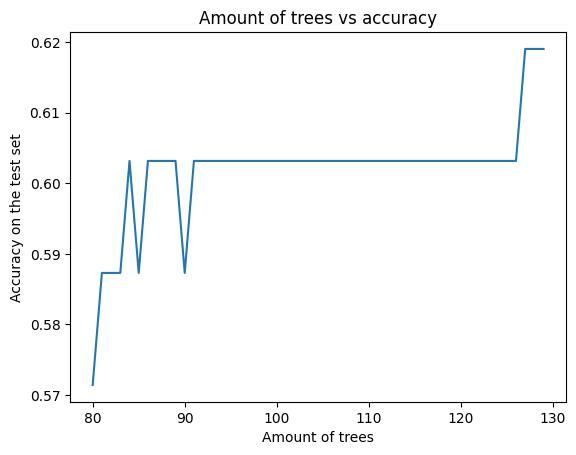

In [64]:
# plot estimators vs acc
import matplotlib.pyplot as plt
plt.plot(lst_estimators, lst_acc)
plt.xlabel('Amount of trees')
plt.ylabel('Accuracy on the test set')
plt.title('Amount of trees vs accuracy')

## You can run this but it takes a lot of time, so I commented it out

In [65]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': list(range(85,105)),
#     'max_depth': list(range(0,20)),
#     'min_samples_split': list(range(1,7)),
#     'min_samples_leaf': list(range(1,7)),
# }

# base_model = RandomForestClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=base_model, param_grid=param_grid, scoring='accuracy', cv=3, verbose=2)
# grid_search.fit(X_train_tfidf, y_train)

# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print("Best Parameters:", best_params)
# print("Best Model Accuracy:", grid_search.best_score_)


Best Parameters: {'max_depth': 8, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 85}
Best Model Accuracy: 0.5873015873015873
This looks even worse

## Using 5fold-CV

In [ ]:
#cv
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.8)),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42, n_estimators=81)))
])

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='f1_macro')

y_pred_cv = cross_val_predict(pipeline, X, y, cv=kf)

print(f"Cross-validated F1 scores: {scores}")
print(f"Mean F1 score: {np.mean(scores):.4f}")
print("Hamming Loss:", hamming_loss(y, y_pred_cv))
print("Classification Report:")
print(classification_report(y, y_pred_cv))

Cross-validated F1 scores: [0.39049431 0.21572349 0.39793567 0.31763196 0.32542147]
Mean F1 score: 0.3294
Hamming Loss: 0.2845659163987138
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08        75
           1       0.53      0.10      0.17        98
           2       0.74      0.15      0.24        96
           3       0.69      0.94      0.80       206

   micro avg       0.69      0.47      0.56       475
   macro avg       0.74      0.31      0.32       475
weighted avg       0.72      0.47      0.44       475
 samples avg       0.66      0.63      0.64       475



c:\Users\hanna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Trying several models with 5 fold CV

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

results = {}
for clf_name, clf_info in classifiers.items():
    print(f"Running GridSearchCV for {clf_name}...")
    
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)),
        ('classifier', MultiOutputClassifier(clf_info['model']))
    ])
    
    grid_search = GridSearchCV(pipeline, clf_info['params'], scoring='f1_macro', cv=kf, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
    
    # Cross-validation predictions and metrics
    y_pred_cv = cross_val_predict(best_model, X_train, y_train, cv=kf)
    f1_scores = cross_val_score(best_model, X_train, y_train, cv=kf, scoring='f1_macro')
    mean_f1_cv = np.mean(f1_scores)
    hamming_cv = hamming_loss(y_train, y_pred_cv)
    report_cv = classification_report(y_train, y_pred_cv)
    
    # Validation predictions and metrics
    y_pred_val = best_model.predict(X_val)
    f1_val = f1_score(y_val, y_pred_val, average='macro')
    hamming_val = hamming_loss(y_val, y_pred_val)
    report_val = classification_report(y_val, y_pred_val)
    
    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'mean_f1_cv': mean_f1_cv,
        'hamming_loss_cv': hamming_cv,
        'classification_report_cv': report_cv,
        'f1_val': f1_val,
        'hamming_loss_val': hamming_val,
        'classification_report_val': report_val
    }
    
    print(f"{clf_name} Results (Cross-Validation):")
    print(f"Mean F1 Score (CV): {mean_f1_cv:.4f}")
    print(f"Hamming Loss (CV): {hamming_cv:.4f}")
    print("Classification Report (CV):")
    print(report_cv)
    
    print(f"{clf_name} Results (Validation):")
    print(f"F1 Score (Validation): {f1_val:.4f}")
    print(f"Hamming Loss (Validation): {hamming_val:.4f}")
    print("Classification Report (Validation):")
    print(report_val)

for clf_name, metrics in results.items():
    print(f"\n{clf_name} Summary:")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"Mean F1 Score (CV): {metrics['mean_f1_cv']:.4f}")
    print(f"Hamming Loss (CV): {metrics['hamming_loss_cv']:.4f}")
    print(f"F1 Score (Validation): {metrics['f1_val']:.4f}")
    print(f"Hamming Loss (Validation): {metrics['hamming_loss_val']:.4f}")


NameError: name 'classifiers' is not defined

In [25]:
from sklearn.metrics import f1_score

classifiers = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__estimator__n_estimators': [50, 100, 200],
            'classifier__estimator__max_depth': [None, 10, 20],
            'classifier__estimator__min_samples_split': [2, 5, 10]
        }
    },
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'params': {
            'classifier__estimator__C': [0.1, 1, 10],
            'classifier__estimator__penalty': ['l2'],
            'classifier__estimator__solver': ['lbfgs']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'classifier__estimator__n_estimators': [50, 100],
            'classifier__estimator__max_depth': [3, 5, 10],
            'classifier__estimator__learning_rate': [0.01, 0.1, 0.2]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'classifier__estimator__n_estimators': [50, 100],
            'classifier__estimator__max_depth': [-1, 10, 20],
            'classifier__estimator__learning_rate': [0.01, 0.1, 0.2]
        }
    }
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for clf_name, clf_info in classifiers.items():
    print(f"Running GridSearchCV for {clf_name}...")
    
    pipeline = Pipeline([
        ('vectorizer', TfidfVectorizer(max_features=5000, ngram_range=(1,2), min_df=2, max_df=0.8)),
        ('classifier', MultiOutputClassifier(clf_info['model']))
    ])
    
    grid_search = GridSearchCV(pipeline, clf_info['params'], scoring='f1_macro', cv=kf, n_jobs=-1)
    grid_search.fit(X, y)
    
    best_model = grid_search.best_estimator_
    print(f"Best parameters for {clf_name}: {grid_search.best_params_}")
    
    #cv
    y_pred_cv = cross_val_predict(best_model, X, y, cv=kf)
    f1_scores_cv = cross_val_score(best_model, X, y, cv=kf, scoring='f1_macro')
    mean_f1_cv = np.mean(f1_scores_cv)
    hamming_cv = hamming_loss(y, y_pred_cv)
    report_cv = classification_report(y, y_pred_cv)

    #val
    y_pred_val = best_model.predict(X_val)
    f1_val = f1_score(y_val, y_pred_val, average='macro')
    hamming_val = hamming_loss(y_val, y_pred_val)
    report_val = classification_report(y_val, y_pred_val)
    
    results[clf_name] = {
        'best_params': grid_search.best_params_,
        'mean_f1_cv': mean_f1_cv,
        'hamming_loss_cv': hamming_cv,
        'classification_report_cv': report_cv,
        'f1_val': f1_val,
        'hamming_loss_val': hamming_val,
        'classification_report_val': report_val
    }
    
    print(f"{clf_name} Results (CV):")
    print(f"Mean F1 Score: {mean_f1_cv:.4f}")
    print(f"Hamming Loss: {hamming_cv:.4f}")
    print("Classification Report:")
    print(report_cv)

    print(f"{clf_name} Results (Validation):")
    print(f"F1 Score: {f1_val:.4f}")
    print(f"Hamming Loss: {hamming_val:.4f}")
    print("Classification Report:")
    print(report_val)

for clf_name, metrics in results.items():
    print(f"\n{clf_name} Summary:")
    print(f"Best Parameters: {metrics['best_params']}")
    print(f"Mean F1 Score (CV): {metrics['mean_f1_cv']:.4f}")
    print(f"Hamming Loss (CV): {metrics['hamming_loss_cv']:.4f}")
    print(f"F1 Score (Validation): {metrics['f1_val']:.4f}")
    print(f"Hamming Loss (Validation): {metrics['hamming_loss_val']:.4f}")

Running GridSearchCV for RandomForest...
Best parameters for RandomForest: {'classifier__estimator__max_depth': 20, 'classifier__estimator__min_samples_split': 2, 'classifier__estimator__n_estimators': 50}
RandomForest Results (CV):
Mean F1 Score: 0.3478
Hamming Loss: 0.2822
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.04      0.07        75
           1       0.59      0.17      0.27        98
           2       0.61      0.15      0.24        96
           3       0.72      0.92      0.80       206

   micro avg       0.69      0.47      0.56       475
   macro avg       0.60      0.32      0.35       475
weighted avg       0.63      0.47      0.46       475
 samples avg       0.66      0.62      0.63       475

RandomForest Results (Validation):
F1 Score: 1.0000
Hamming Loss: 0.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
       

The validation data is not really meaningful here.
If I focus in the precision, the best models are RandomForest and LogisticRegression.

I will go with the LR and label my unlabelled data

In [68]:
X_unlabelled = unlabelled_data[['content_title', 'content_description', 'content_body']].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
y_unlabelled = unlabelled_data[['Fake News', 'Extreme bias', 'clickbait', 'credible']]

In [69]:
#Best parameters for LogisticRegression: {'classifier__estimator__C': 10, 'classifier__estimator__penalty': 'l2', 'classifier__estimator__solver': 'lbfgs'}
vectorizer = best_model.named_steps['vectorizer']
transformed_data = vectorizer.transform(X_unlabelled)

In [70]:
transformed_data

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1106003 stored elements and shape (5109, 5000)>

In [ ]:
lm = LogisticRegression(penalty="l2", solver="lbfgs", C=10)
moc = MultiOutputClassifier(lm)

X = vectorizer.transform(X)

moc.fit(X, y)

MultiOutputClassifier(estimator=LogisticRegression(C=10))

In [72]:
predictions = moc.predict(transformed_data)

In [26]:
predictions
#on a first glance we can already see that we do not only predict credible data. nice

NameError: name 'predictions' is not defined

In [77]:
list_0 = predictions[:, 0].tolist()
list_1 = predictions[:, 1].tolist()
list_2 = predictions[:, 2].tolist()
list_3 = predictions[:, 3].tolist()

# Print the lists
print("List 0:", list_0)
print("List 1:", list_1)
print("List 2:", list_2)
print("List 3:", list_3)

List 0: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [80]:
unlabelled_data["Fake News"] = pd.Series(list_0)
unlabelled_data["Extreme bias"] = pd.Series(list_1)
unlabelled_data["clickbait"] = pd.Series(list_2)
unlabelled_data["credible"] = pd.Series(list_3)

In [81]:
unlabelled_data

,news_outlet,provenance,query_keywords,creation_date,last_modified,crawl_date,author_person,author_organization,news_keywords,content_title,content_description,content_body,Fake News,Extreme bias,clickbait,credible,body_len,has_label
0,bild,https://www.bild.de/politik/inland/politik-inl...,"spd, fdp, umweltschutz, christian lindner",2024-02-01,2024-02-01,2024-10-20,NaN,BILD,"FDP, die Gruenen, SPD, Lindner Christian, Djir...",Naechster Ampel-Zoff: FDP stoppt Lieferketten-...,Naechster Keil zwischen den Ampel-Parteien! Zw...,Naechster Keil zwischen den Ampel-Parteien! D...,0.0,0.0,0.0,1.0,2326.0,False
1,bild,https://www.bild.de/politik/inland/politik-inl...,"migration, rki, spd, cdu",2022-06-18,2022-06-18,2024-10-20,"Oliver Grothmann, Stephan Kuerthy, Michael Eng...",NaN,"Berlin, Organisiertes Verbrechen, Bushido, Ras...",Aufschrei der Anstaendigen - Jetzt sprechen di...,"Es reicht das sagen immer mehr von denen, die...",Es rumort unter Deutschlands Buergern. Es rei...,0.0,1.0,1.0,0.0,4146.0,False
2,bild,https://www.bild.de/politik/inland/politik-inl...,"spd, inflation, cdu",2023-05-11,2023-05-11,2024-10-20,Karina Moessbauer,NaN,"Bundeswehr, texttospeech",Verteidigungsministerium sieht kein Problem: B...,Die Bundeswehr bestellt neue Loeschfahrzeuge ...,"Verteidigungsminister Boris Pistorius (63, SPD...",0.0,0.0,0.0,1.0,2497.0,False
3,bild,https://www.bild.de/politik/inland/politik-inl...,"migration, integration, grenzen, spd, cdu",2023-04-08,2023-04-08,2024-10-20,Zara Riffler und Daniela Pfad,NaN,"innenministerium, Politik, Politik-Inland, mig...",Faeser riskiert den Zusammenhalt! Landraete-Au...,Nachdem die Bundesinnenministerin sich gegen m...,Wirbel um Aussagen von Bundesinnenministerin N...,0.0,0.0,0.0,1.0,3806.0,False
4,bild,https://www.bild.de/politik/kolumnen/kolumne/s...,"spd, verschwoerungstheorien, olaf scholz",2022-04-18,2022-04-18,2024-10-20,Paul Ronzheimer,NaN,"Russland, Ukraine, putin wladimir, Scholz Olaf...","Kommentar: Schweigen zu Kreml-Gerd, Wut auf Bo...","Die SPD schweigt zu Gerhard Schroeder, ist abe...",Die kalte Selbstgerechtigkeit einiger SPD-Poli...,0.0,0.0,1.0,1.0,2642.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5104,welt,https://www.welt.de/kmpkt/article244742914/Kal...,"sp, ss, ns",2023-06-26,2023-06-26,2024-10-20,NaN,NaN,"kmpkt, Tiefsee, Tiefseeexpeditionen, Kalmare, ...",Kalmar im Atlantik: Diese Kreatur erinnert an ...,"In der Tiefsee schwimmt eine Kreatur, die laut...","In der Tiefsee schwimmt eine Kreatur, die laut...",0.0,0.0,0.0,1.0,2866.0,False
5105,welt,https://www.welt.de/iconist/unterwegs/article2...,"sp, corona, lockdown, ns, spo, pandemie, ss",2023-12-12,2023-12-12,2024-10-20,NaN,NaN,"Hinrichs-Per, Dorfportraets, Kommunen, Rekorde...",Die zehn kuriosesten Doerfer Deutschlands - Ei...,"Mehrere Meter unter dem Meeresspiegel, tausend...","Mehrere Meter unter dem Meeresspiegel, tausend...",0.0,0.0,0.0,1.0,3686.0,False
5106,welt,https://www.welt.de/wirtschaft/article24486286...,"sp, ns, spo, tesla, schi, demo, ss",2023-04-18,2023-04-18,2024-10-20,NaN,NaN,"Newsteam, Kuenstliche Intelligenz (KI), Musk, ...",Tucker Carlson: Elon Musk will mit TruthGPT di...,Im TV Sender Fox News hat Elon Musk seine Plae...,Im TV Sender Fox News hat Elon Musk seine Plae...,0.0,0.0,0.0,1.0,2912.0,False
5107,welt,https://www.welt.de/iconist/maenner/article222...,"christ, sp, ns, homeoffice, ss",2020-12-26,2023-04-14,2024-10-20,NaN,NaN,"Herrenmode, Bekleidungsindustrie, Cassier-Phil...",Shaping new tomorrow: Diese Daenen machen Mode...,"Bequem, nachhaltig und stylish die Anprueche ...","Bequem, nachhaltig und stylish die Anprueche ...",0.0,0.0,1.0,0.0,3647.0,False


We now apply this model to the unlabelled data.

In [82]:
unlabelled_data.to_csv("finished_data.csv")

For fake news detection, i think these % are acceptable. Even as a human, it is sometimes difficult to tell and decide the category. Therefore it is better, to have a higher precision

I will now leave this and continue with the task. If i have time i will come back